<a href="https://colab.research.google.com/github/AlbertRoca29/EconomiaCircular/blob/main/Script_exploraci%C3%B3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [317]:
#@title Import data and libraries
import pandas as pd
import numpy as np
import time
import zipfile
import io
import requests
from matplotlib import pyplot as plt

# Tweets comptes 
urlT = 'https://github.com/AlbertRoca29/EconomiaCircular/blob/main/Tweets.csv?raw=true'
T = pd.read_csv(urlT)

# Tweets tots
urlTAll = 'https://github.com/AlbertRoca29/EconomiaCircular/blob/main/Tweets_All.xlsx?raw=true'
T_All = pd.read_excel(urlTAll,engine='openpyxl')


In [318]:
#@title <h5> Fix some variables 
# Datetime format
T['Date'] = pd.to_datetime(T['Date'])
T_All['Date'] = pd.to_datetime(T_All['Date'])

# Remove year 2023
T = T[(T['Date'].dt.year > 2007) & (T['Date'].dt.year < 2023)]
T_All = T_All[(T_All['Date'].dt.year > 2007) & (T_All['Date'].dt.year < 2023)]

# Index
T['Index'] = 1 + np.log(1+ T_All['Retweets'])
T_All['Index'] = 1 + np.log(1+ T_All['Retweets'])



**Dates selected** : from 01-01-2008 to 31-12-2022

**Formula for indices**: Index of the tweet ($Index$), number of retweets ($R$)

$ Index = 1 + log(1+ R) $


| Paraules | 
|:-|
Minimització de residus
Producció neta
Zero emissions / Emissions zero
Economia verda
Triple balanç
Reciclatge
Avaluació del Cicle de Vida / Anàlisi del Cicle de Vida
Consum sostenible
decreixement / Creixement zero / Zero creixement, 
Responsabilitat Social Corporativa / RSC
Responsabilitat Social Universitaria / RSU
Economia blava
Creació de valor compartit / Valor compartit
Ecologia industrial
Economia col·laborativa
Economia circular


# Anàlisi dels twits dels comptes escollits



In [320]:
#@title Grups i comptes escollits

Comptes = {
    'Diaris': ['diariARA','elnacionalcat','VilaWeb','324cat','CatalunyaRadio','rac1'],
    'Administracions Públiques': ['govern','generalitat' ,'gencat' ,'diba','DiputacioGirona' ,'DiputacioLleida' ,'Dipta_cat'],
    'Universitats': ['uabbarcelona ','uabbarcelona ','upfbarcelona ','la_upc ','univgirona ','UdL_info ','universitatURV '],
    'Patronals': ['pimec ','FomentTreball ','PatronalCecot'],
    'Sindicats': ['ccoocatalunya ','ugtcatalunya ','cgtcatalunya ','LaIntersindical'],
}

# find the maximum length of any email list
max_len = max([len(email_list) for email_list in Comptes.values()])

# pad shorter lists with empty strings
for email_list in Comptes.values():
    while len(email_list) < max_len:
        email_list.append('')

# print the group headers
for group in Comptes.keys():
    print(f"{group.capitalize():<29}", end='')
print()

# print a separator line
print("-" * (29 * len(Comptes)))

# print the emails in columns
for i in range(max_len):
    for group, email_list in Comptes.items():
        print(f"{email_list[i]:<29}", end='')
    print()




Diaris                       Administracions públiques    Universitats                 Patronals                    Sindicats                    
-------------------------------------------------------------------------------------------------------------------------------------------------
diariARA                     govern                       uabbarcelona                 pimec                        ccoocatalunya                
elnacionalcat                generalitat                  uabbarcelona                 FomentTreball                ugtcatalunya                 
VilaWeb                      gencat                       upfbarcelona                 PatronalCecot                cgtcatalunya                 
324cat                       diba                         la_upc                                                    LaIntersindical              
CatalunyaRadio               DiputacioGirona              univgirona                                                        

In [321]:
#@title Nombre de twits (reals i seguint l'index) 2008 - Actualitat per a cada organització

T['Index'] = 1+ np.log(1+ T['Retweets'])

Tgrup = T.groupby('Grup')["Index"].agg({"size",'sum'}).rename(columns={"size": "Twits", "sum": "Twits index"}).astype({"Twits index": int}).reset_index('Grup')

Tgrup['% Twits'] = (Tgrup['Twits'] / Tgrup['Twits'].sum() * 100).round(1)
Tgrup['% Twits index'] = (Tgrup['Twits index'] / Tgrup['Twits index'].sum() * 100).round(1)

print(Tgrup.to_string(index=False))

                    Grup  Twits  Twits index  % Twits  % Twits index
Administracions_Pubiques    260          573     26.8           26.2
                  Diaris    427          995     44.0           45.5
               Patronals    123          252     12.7           11.5
               Sindicats     58          139      6.0            6.4
            Universitats    103          228     10.6           10.4


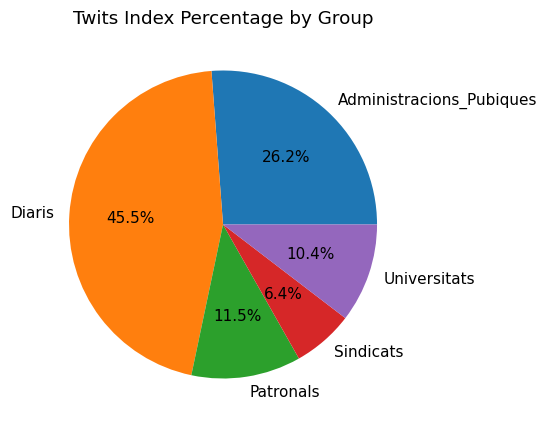

In [322]:
#@title Group Pie chart, per Twits Index

plt.figure(figsize=(5,5))
plt.pie(Tgrup['% Twits index'], labels=Tgrup['Grup'], autopct='%1.1f%%')
plt.title('Twits Index Percentage by Group')
plt.show()


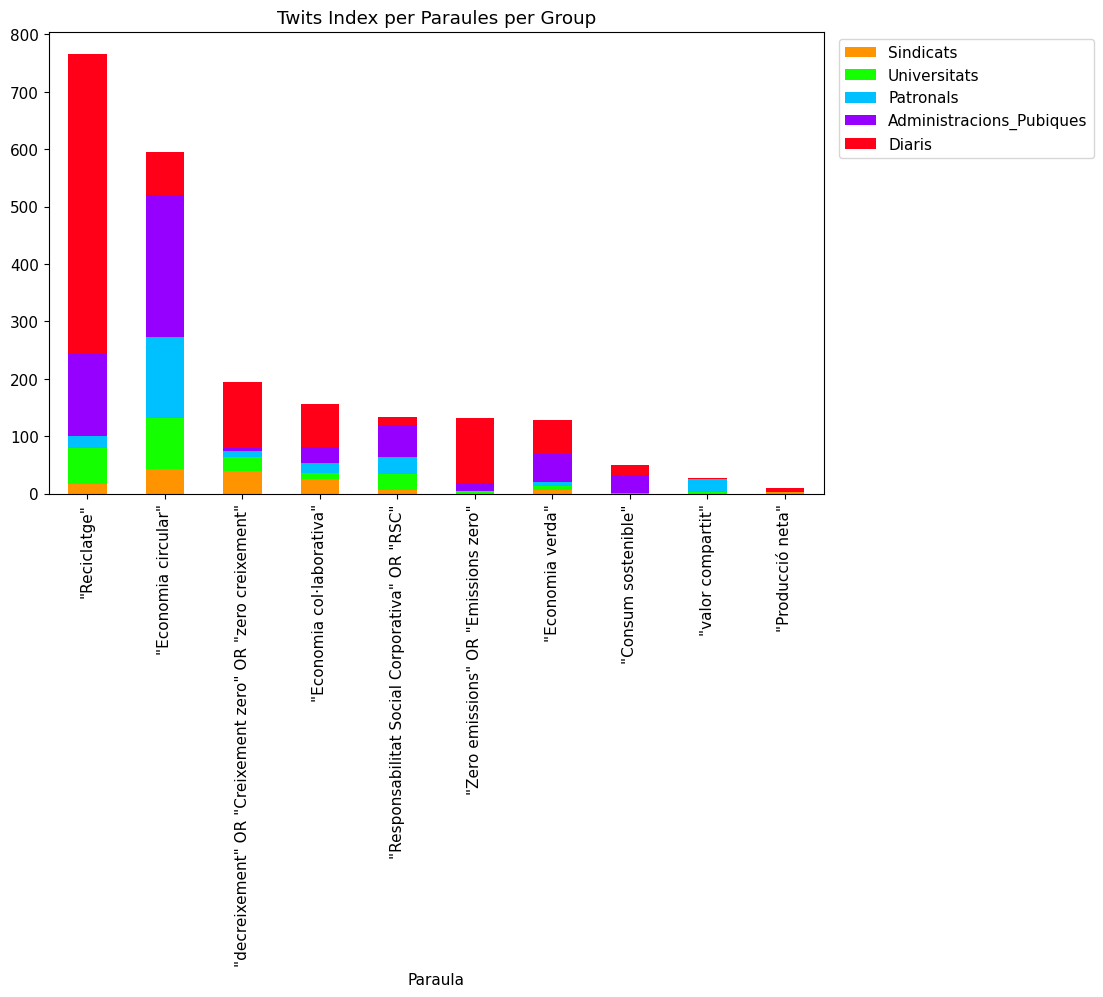

In [323]:
#@title Paraules Bar Plot, per Twits Index

plt.figure(figsize=(10,6))
hsv = plt.get_cmap('hsv')
colors = hsv(np.linspace(0.1, 1, len(np.unique(T['Grup']))))

bot = T.groupby(['Paraula','Grup'])['Index'].sum().groupby('Paraula').sum()

ind = np.argsort(bot)[::-1]

bot = bot[ind]-bot[ind]

zero = bot.copy()

plt.title('Twits Index per Paraules per Group')

for i, grup in enumerate(list(T['Grup'].value_counts().sort_values().keys())):
    T_p = T[T['Grup']==grup]
    Pr = ((zero + T_p.groupby('Paraula')['Index'].sum())[ind]).fillna(0)
    Pr.plot(kind='bar',color=colors[i],label=grup,bottom=bot)
    bot += Pr
    plt.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left')
plt.show()


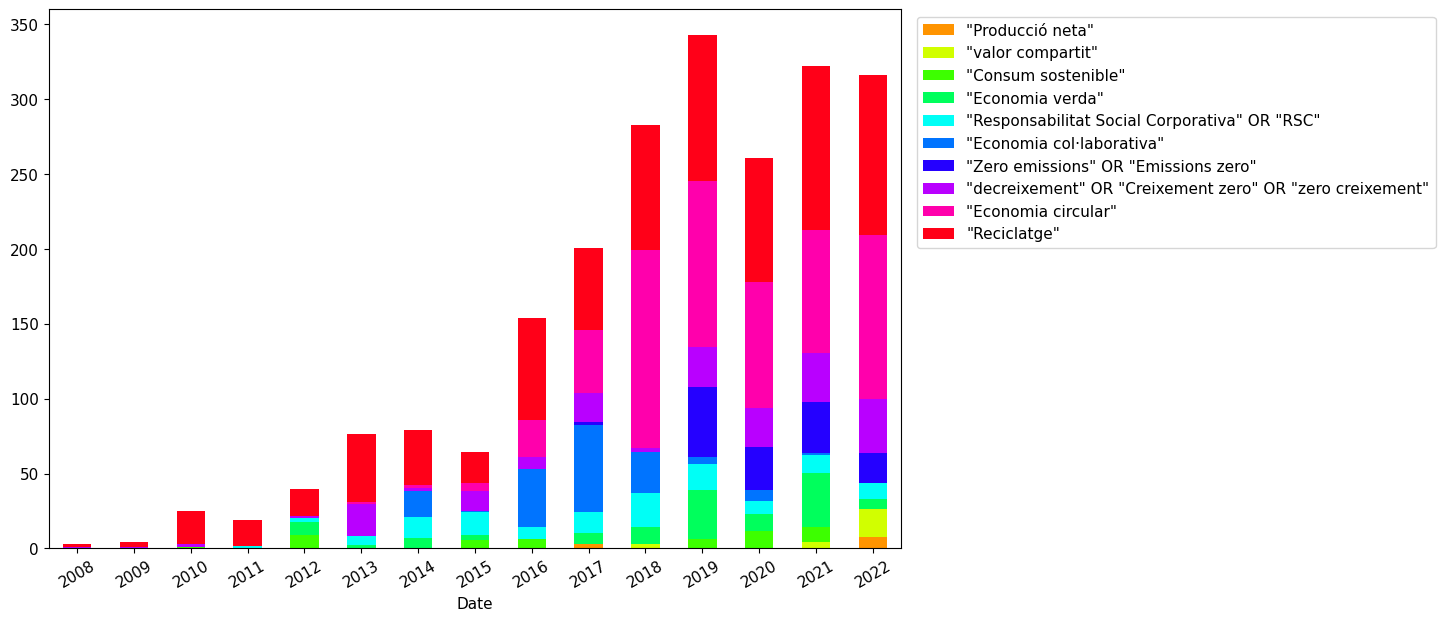

In [324]:
#@title Evolució del nombre de Twits Index en cada paraula per any

plt.figure(figsize=(11,7))
hsv = plt.get_cmap('hsv')
colors = hsv(np.linspace(0.1, 1, len(np.unique(T['Paraula']))))
bot = T.groupby(pd.Grouper(key='Date', freq='Y'))['Index'].sum()

bot -= bot
zero = bot.copy()

for i, paraula in enumerate(list(T['Paraula'].value_counts().sort_values().keys())):
    T_p = T[T['Paraula']==paraula]
    year = (zero + T_p.groupby(pd.Grouper(key='Date', freq='Y'))['Index'].sum()).fillna(0)
    year.plot(kind='bar',color=colors[i],label=paraula,bottom=bot)
    bot += year
    plt.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left')
plt.xticks(np.arange(15), np.arange(2008,2023),rotation=30)
plt.show()

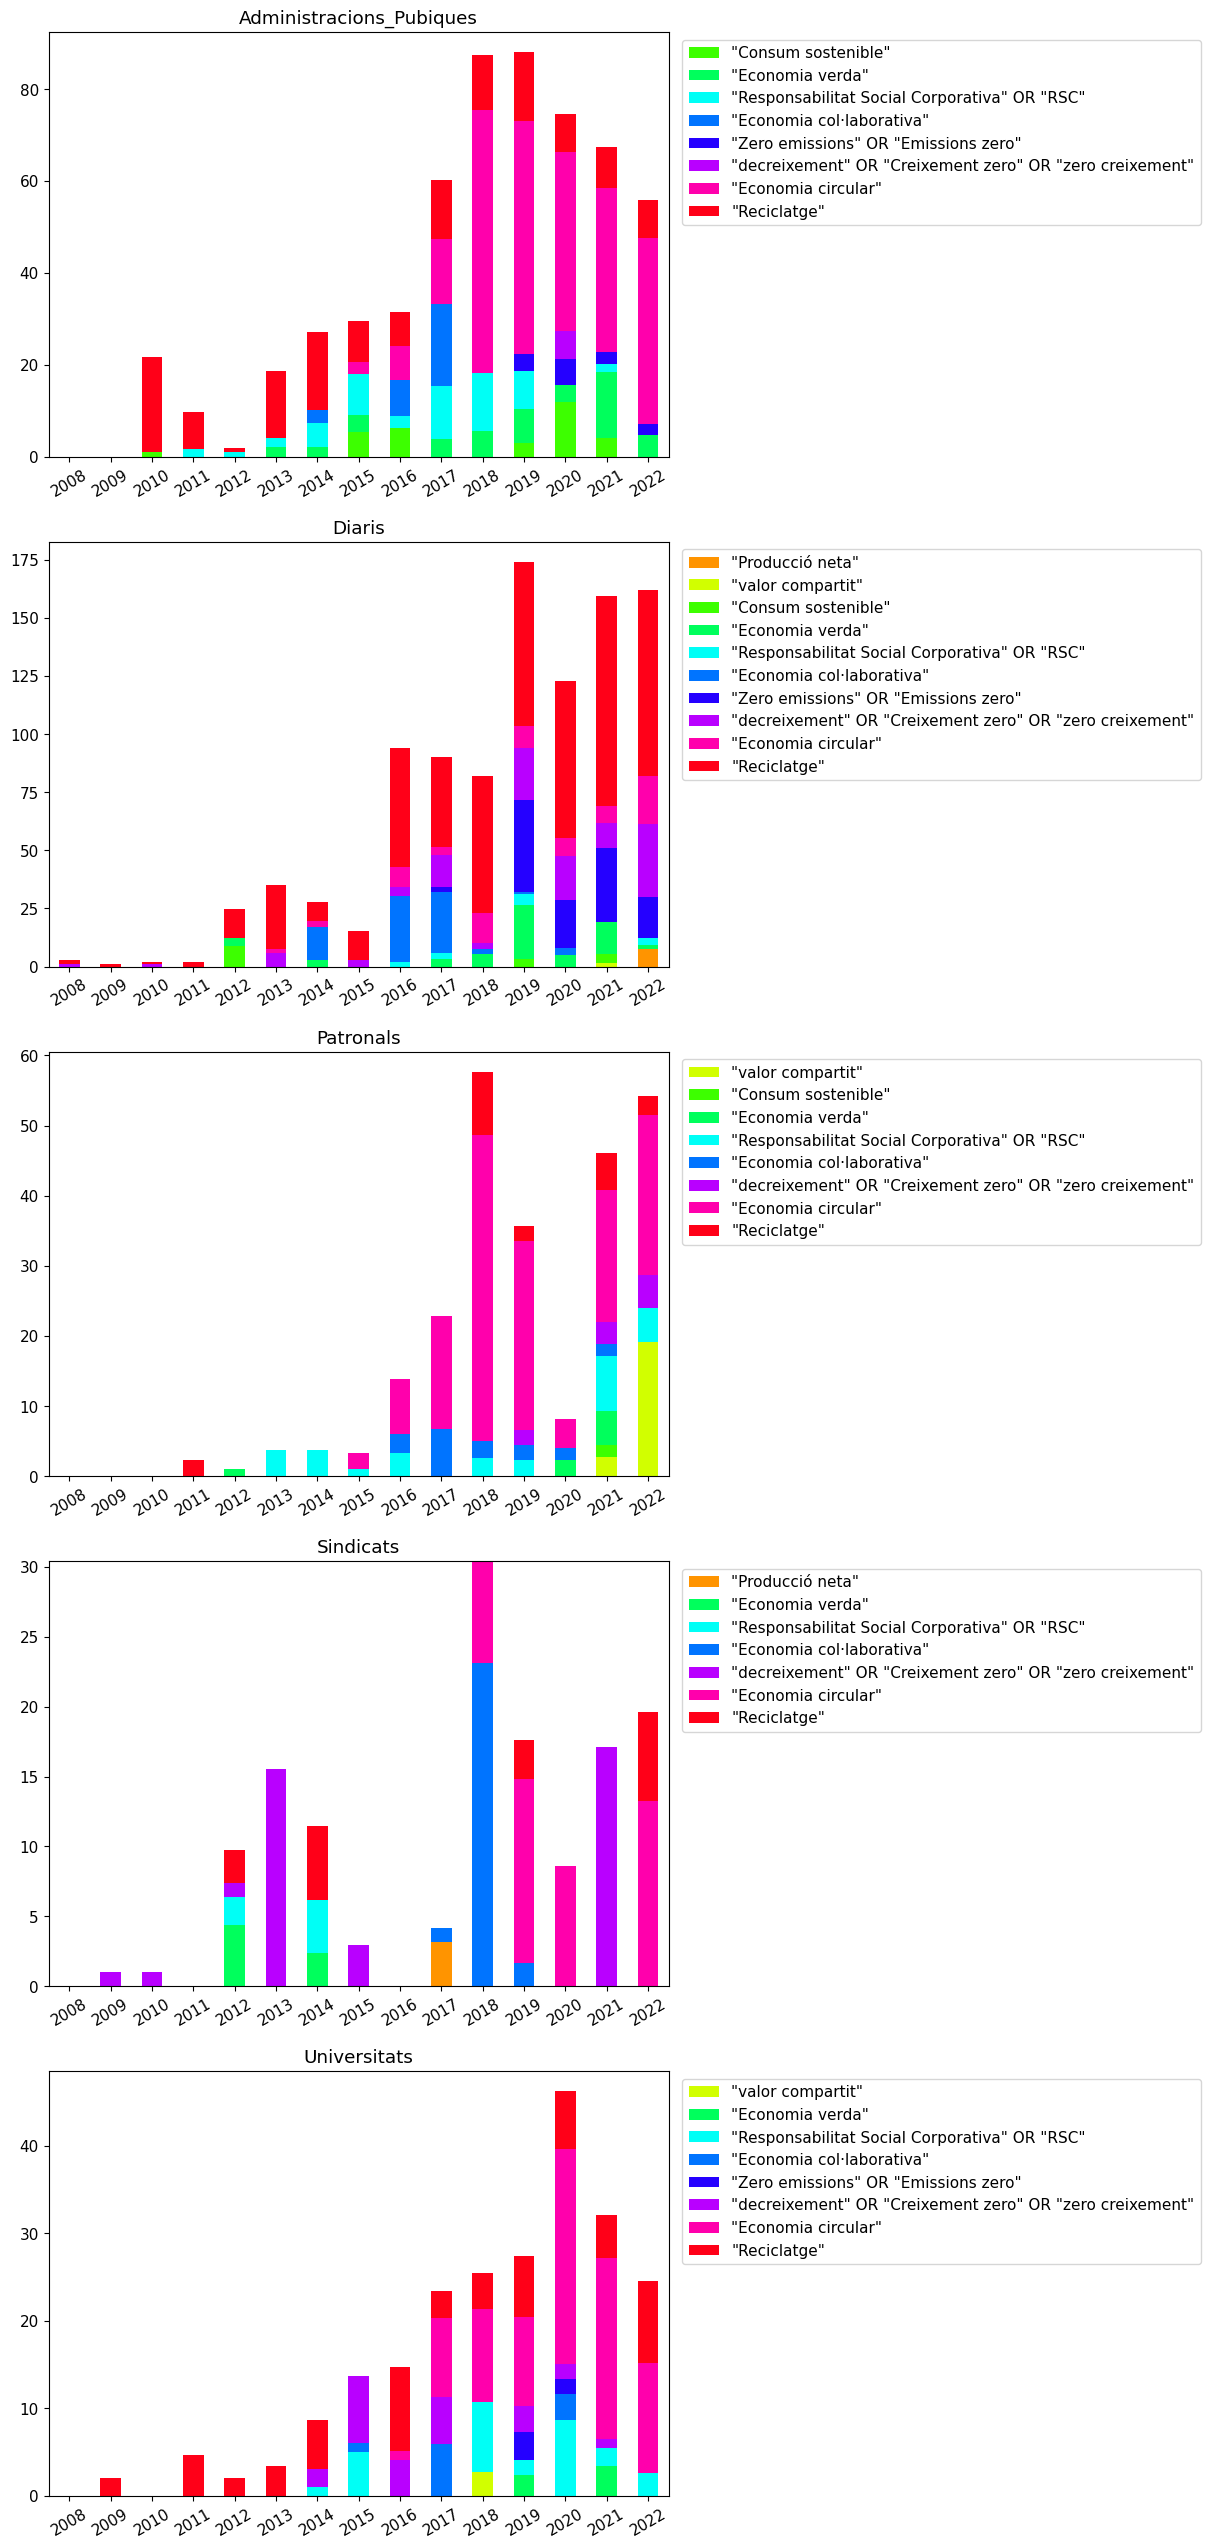

In [325]:
#@title Mateix gràfic separat per grups
plt.figure(figsize=(8,32))
for j,group in enumerate(np.unique(T['Grup'])):
    ax = plt.subplot(5,1,j+1)
    bot = zero.copy()
    Tg = T[T['Grup']==group]
    for i, paraula in enumerate(list(T['Paraula'].value_counts().sort_values().keys())):
        if(np.sum(Tg['Paraula']==paraula)>0):
            Tp = Tg[Tg['Paraula']==paraula]
            year = (zero + Tp.groupby(pd.Grouper(key='Date', freq='Y'))['Index'].sum()).fillna(0)
            year.plot(kind='bar',color=colors[i],label=paraula,bottom=bot)
            bot += year
            plt.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left')
    plt.xticks(np.arange(15), np.arange(2008,2023),rotation=30)
    plt.title(group)
    ax.set_xlabel('')
plt.show()

# Anàlisi de tots els twits en català que continguin les paraules


In [326]:
#@title <h5> fix some variable
T_All['Date'] = pd.to_datetime(T_All['Date'],errors='coerce')

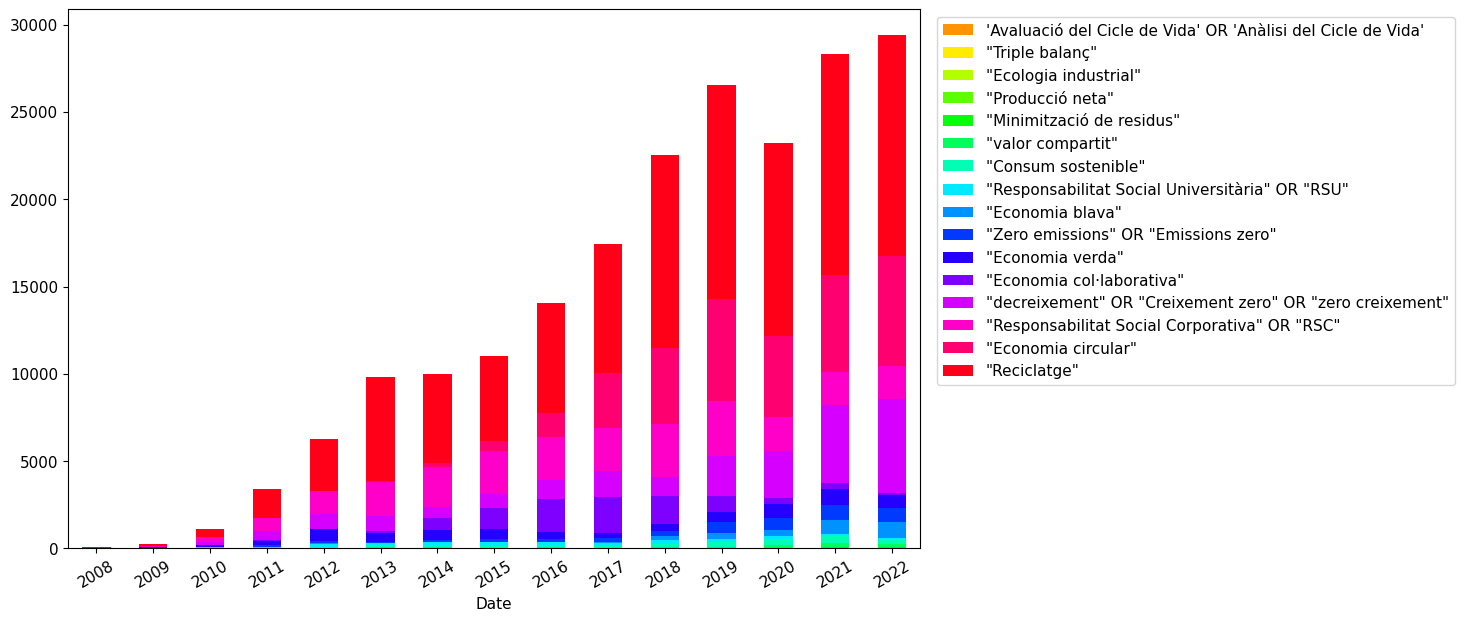

In [327]:
#@title Evolució del nombre de Twits Index en cada paraula per any
plt.figure(figsize=(11,7))
hsv = plt.get_cmap('hsv')
colors = hsv(np.linspace(0.1, 1, len(np.unique(T_All['Paraula']))))
bot = T_All.groupby(pd.Grouper(key='Date', freq='Y'))['Index'].sum()
bot -= bot
zero = bot.copy()

for i, paraula in enumerate(list(T_All['Paraula'].value_counts().sort_values().keys())):
    T_p = T_All[T_All['Paraula']==paraula]
    year = (zero + T_p.groupby(pd.Grouper(key='Date', freq='Y'))['Index'].sum()).fillna(0)
    year.plot(kind='bar',color=colors[i],label=paraula,bottom=bot)
    bot += year
    plt.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left')
plt.xticks(np.arange(15), np.arange(2008,2023),rotation=30)
plt.show()

In [328]:
#@title Percentatge de twits amb localització

print('Percentatge de twits amb localització : {:.3} %'.format(sum(~pd.isna(T_All['Coords']))/len(T_All['Coords'])*100))

print("Percentatge d'usuaris únics representats : {:.3} %".format(len(T_All[~pd.isna(T_All['Coords'])].User.unique())/len(T_All.User.unique())*100))

Percentatge de twits amb localització : 3.19 %
Percentatge d'usuaris únics representats : 6.34 %


In [329]:
#@title <h5>Extreure latitud i longitud
def extreure(coordenada,xy='long'):
    if(type(coordenada)!=str):
        return coordenada
    lon, lat = coordenada.replace("Coordinates(", "").replace(")", "").replace("longitude=", "").replace("latitude=", "").split(",")
    if(xy=='long'):
        return float(lon)
    return float(lat)

T_All["long"] = T_All["Coords"].apply(extreure,xy = 'long')
T_All["lat"] = T_All["Coords"].apply(extreure,xy = 'lat')

In [330]:
#@title Mapa
import plotly.express as px
import pandas as pd

mapbox_token = "pk.eyJ1IjoiYXp1YmFyY28iLCJhIjoiY2s0OHRtbDNsMGI5YTNrcHJueWV3N20zdCJ9.qpTrQEyiBNskROz38Ggc3Q" 

fig = px.scatter_mapbox(T_All,
                        lat="lat",
                        lon="long",
                        zoom=4,
                        size='Index')

fig.update_layout(mapbox_accesstoken=mapbox_token)
fig.write_html("mapa.html")
fig.show()
